# MTA-LSTM-PyTorch

This is an implementation of the paper [Topic-to-Essay Generation with Neural Networks](http://ir.hit.edu.cn/~xcfeng/xiaocheng%20Feng's%20Homepage_files/final-topic-essay-generation.pdf). The original work can be found [here](https://github.com/hit-computer/MTA-LSTM), which is implemented in TensorFlow and is totally out-of-date, further more, the owner doesn't seem to maintain it anymore. Therefore, I decided to re-implement it in a simple yet powerful framework, PyTorch.

In this notebook, I'll show you how to build a neural network proposed in the paper step by step from scratch.

## Import packages

The followings are some packages that'll be used in this work. Make sure you have them installed.

In [1]:
import gensim
from gensim.models import KeyedVectors
import numpy as np
import torch
from torch import nn, autograd, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Parameter, LayerNorm
from torch.autograd import Variable
import torch.jit as jit
import torch.nn.functional as F
import time
import os
import math
from tqdm import tqdm
import collections
from collections import namedtuple
import random

In [2]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip"
# !unzip NotoSansCJKtc-hinted.zip
# !sudo mv NotoSansCJKtc-Black.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Bold.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-DemiLight.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Light.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Medium.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Regular.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Thin.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansMonoCJKtc-Bold.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/

In [3]:
import matplotlib.font_manager as fm
import matplotlib.font_manager as font_manager

font_dirs = ['/fonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
# font_list = font_manager.createFontList(font_files)
# font_manager.fontManager.ttflist.extend(font_list)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

path = 'fonts/NotoSansSC-Regular.otf'
fontprop = fm.FontProperties(fname=path)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
print('Available cuda:', torch.cuda.device_count())
if torch.cuda.is_available():
    device_num = 1
    deviceName = "cuda:%d" % device_num
    torch.cuda.set_device(device_num)
    print('Current device:', torch.cuda.current_device())
else:
    deviceName = "cpu"
    
device = torch.device(deviceName)

Available cuda: 0


## Build a dictionary and pretrained embedding system

Here I'm gonna load the pretrained word2vec vocab and vectors. Please refer to [this notebook]() to he how to train it.

The code ```fvec.vectors``` is where we get the pretrained vectors.
```<PAD>```, ```<BOS>```, ```<EOS>``` and ```<UNK>``` are 4 common tokens which stands for **PADding**, **Begin-Of-Sentence**, **End-Of-Sentence** and **UNKnown** respectively. We simply add them into the vocabularies.

In [5]:
save_folder = 'model_result_multi_layer'

vocab_check_point = '%s/vocab.pkl' % save_folder
word_vec_check_point = '%s/word_vec.pkl' % save_folder

if os.path.exists(vocab_check_point) and os.path.exists(word_vec_check_point):
    vocab = torch.load(vocab_check_point)
    word_vec = torch.load(word_vec_check_point)
else:
    file_path = 'data/'
    
    fvec = KeyedVectors.load_word2vec_format(file_path+'composition_mincount_1_305000_vec_original.txt', binary=False)
    
    word_vec = fvec.vectors
    
    vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
    vocab.extend(list(fvec.index_to_key))
    
    word_vec = np.concatenate((np.array([[0]*word_vec.shape[1]] * 4), word_vec))
    word_vec = torch.tensor(word_vec).float()
    
    del fvec
    
    torch.save(vocab, vocab_check_point)
    torch.save(word_vec, word_vec_check_point)
    
print("total %d words" % len(word_vec))

total 189613 words


## Build a word-index convertor

We don't want to use type of string directly when training, instead we map them to a unique index in integer. In text generation phase, we'll then convert them back to string.

In [6]:
word_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_word = {i: ch for i, ch in enumerate(vocab)}

## Load preprocessed data

You can prepare for your own data, or simply use what I offered in the data folder.

In [7]:
essays = []
topics = []

file_path = 'data/'
file_name = 'zhihu_small.txt'  ### TODO

num_lines = sum(1 for line in open(file_path+file_name, 'r'))
with open(file_path+file_name) as f:
    for line in tqdm(f, total=num_lines):
        essay, topic = line.replace('\n', '').split(' </d> ')
        essays.append(essay.split(' '))
        topics.append(topic.split(' '))
#     f.close()
    
assert len(topics) == len(essays)
print(len(topics))

100%|██████████| 10000/10000 [00:00<00:00, 58585.15it/s]

10000


We then map all the training and testing corpus to integer index word-by-word, with the help of our convertor. Note that we map it to ```<UNK>``` if the words in corpus are not in the dictionary.

In [8]:
split_index = int(len(topics) * 0.985)

corpus_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[:split_index])))
topics_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[:split_index])))
corpus_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[split_index:])))
topics_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[split_index:])))

100%|██████████| 150/150 [00:00<00:00, 48710.56it/s]


In [9]:
def viewData(topics, X):
    topics = [idx_to_word[x] for x in topics]
    X = [idx_to_word[x] for x in X]
    print(topics, X)

In [10]:
from random import shuffle

def shuffleData(topics_indice, corpus_indice):
    ind_list = [i for i in range(len(topics_indice))]
    shuffle(ind_list)
    topics_indice = np.array(topics_indice)
    corpus_indice = np.array(corpus_indice)
    topics_indice = topics_indice[ind_list,]
    corpus_indice = corpus_indice[ind_list,]
    topics_indice = topics_indice.tolist()
    corpus_indice = corpus_indice.tolist()
    return topics_indice, corpus_indice

# topics_indice, corpus_indice = shuffleData(topics_indice, corpus_indice)
# viewData(topics_indice[0], corpus_indice[0])

In [11]:
for t in topics_indice:
    if len(t) != 5:
        print('less than 5')

We need to know the max length of training corpus too, in order to pad sequences that aren't long enough.

In [12]:
length = list(map(lambda x: len(x), corpus_indice))

Delete useless dependencies to free up some space.

In [13]:
del essays
del topics

## Batch data iterator

We want to iter through training data in batches and feed them into the network, and this is how we prepare for it:

In [14]:
def data_iterator(corpus_indice, topics_indice, batch_size, num_steps):
    epoch_size = len(corpus_indice) // batch_size
    for i in range(epoch_size):
        raw_data = corpus_indice[i*batch_size: (i+1)*batch_size]
        key_words = topics_indice[i*batch_size: (i+1)*batch_size]
        data = np.zeros((len(raw_data), num_steps+1), dtype=np.int64)
        for i in range(batch_size):
            doc = raw_data[i]
            tmp = [1]
            tmp.extend(doc)
            tmp.extend([2])
            tmp = np.array(tmp, dtype=np.int64)
            _size = tmp.shape[0]
            data[i][:_size] = tmp
        key_words = np.array(key_words, dtype=np.int64)
        x = data[:, 0:num_steps]
        y = data[:, 1:]
        mask = np.float32(x != 0)
        x = torch.tensor(x)
        y = torch.tensor(y)
        mask = torch.tensor(mask)
        key_words = torch.tensor(key_words)
        yield(x, y, mask, key_words)

## Build model: MTA-LSTM

This is the most important part in the notebook.

### Bahdanau Attention

In [15]:
class Attention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, embed_size):
        super(Attention, self).__init__()
        
        self.Ua = nn.Linear(embed_size, hidden_size, bias=False)
        self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        self.va = nn.Linear(hidden_size, 1, bias=True)
        # to store attention scores
        self.alphas = None
        
    def forward(self, query, topics, coverage_vector):
        scores = []
        C_t = coverage_vector.clone()
        for i in range(topics.shape[1]):
            proj_key = self.Ua(topics[:, i, :])
            query = self.Wa(query)
            scores += [self.va(torch.tanh(query + proj_key)) * C_t[:, i:i+1]]
            
        # stack scores
        scores = torch.stack(scores, dim=1)
        scores = scores.squeeze(2)
#         print(scores.shape)
        # turn scores to probabilities
        alphas = F.softmax(scores, dim=1)
        self.alphas = alphas
        
        # mt vector is the weighted sum of the topics
        mt = torch.bmm(alphas.unsqueeze(1), topics)
        mt = mt.squeeze(1)
        
        # mt shape: [batch x embed], alphas shape: [batch x num_keywords]
        return mt, alphas

### Attention Decoder

In [16]:
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, embed_size, num_layers, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # topic attention
        self.attention = Attention(hidden_size, embed_size)
        
        # lstm
        self.rnn = nn.LSTM(input_size=embed_size * 2, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers, 
                           dropout=dropout)
        
    def forward(self, input, output, hidden, phi, topics, coverage_vector):
        # 1. calculate attention weight and mt
        mt, score = self.attention(output.squeeze(0), topics, coverage_vector)
        mt = mt.unsqueeze(1).permute(1, 0, 2)
        
        # 2. update coverge vector [batch x num_keywords]
        coverage_vector = coverage_vector - score / phi
        
        # 3. concat input and Tt, and feed into rnn 
        output, hidden = self.rnn(torch.cat([input, mt], dim=2), hidden)
        
        return output, hidden, score, coverage_vector

### MTA-LSTM model

In [17]:
LSTMState = namedtuple('LSTMState', ['hx', 'cx'])
class MTALSTM(nn.Module):
    def __init__(self, hidden_dim, embed_dim, num_keywords, num_layers, weight,
                 num_labels, bidirectional, dropout=0.5, **kwargs):
        super(MTALSTM, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_labels = num_labels
        self.bidirectional = bidirectional
        if num_layers <= 1:
            self.dropout = 0
        else:
            self.dropout = dropout
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.Uf = nn.Linear(embed_dim * num_keywords, num_keywords, bias=False)
        
        # attention decoder
        self.decoder = AttentionDecoder(hidden_size=hidden_dim, 
                                        embed_size=embed_dim, 
                                        num_layers=num_layers, 
                                        dropout=dropout)
        
        # adaptive softmax
        self.adaptiveSoftmax = nn.AdaptiveLogSoftmaxWithLoss(hidden_dim, 
                                                             num_labels, 
                                                             cutoffs=[round(num_labels / 20), 4*round(num_labels / 20)])
    
    def forward(self, inputs, topics, output, hidden=None, mask=None, target=None, coverage_vector=None, seq_length=None):
        embeddings = self.embedding(inputs)
        topics_embed = self.embedding(topics)
        ''' calculate phi [batch x num_keywords] '''
        phi = None
        phi = torch.sum(mask, dim=1, keepdim=True) * torch.sigmoid(self.Uf(topics_embed.reshape(topics_embed.shape[0], -1).float()))
        
        # loop through sequence
        inputs = embeddings.permute([1, 0, 2]).unbind(0)
        output_states = []
        attn_weight = []
        for i in range(len(inputs)):
            output, hidden, score, coverage_vector = self.decoder(input=inputs[i].unsqueeze(0), 
                                                                        output=output, 
                                                                        hidden=hidden, 
                                                                        phi=phi, 
                                                                        topics=topics_embed, 
                                                                        coverage_vector=coverage_vector) # [seq_len x batch x embed_size]
            output_states += [output]
            attn_weight += [score]
            
        output_states = torch.stack(output_states)
        attn_weight = torch.stack(attn_weight)
        
        # calculate loss py adaptiveSoftmax
        outputs = self.adaptiveSoftmax(output_states.reshape(-1, output_states.shape[-1]), target.t().reshape((-1,)))
        
        return outputs, output_states, hidden, attn_weight, coverage_vector
    
    def inference(self, inputs, topics, output, hidden=None, mask=None, coverage_vector=None, seq_length=None):
        embeddings = self.embedding(inputs)
        topics_embed = self.embedding(topics)
       
        phi = None
        phi = seq_length.float() * torch.sigmoid(self.Uf(topics_embed.reshape(topics_embed.shape[0], -1).float()))
        
        queries = embeddings.permute([1, 0, 2])[-1].unsqueeze(0)
        
        inputs = queries.permute([1, 0, 2]).unbind(0)
        output_states = []
        attn_weight = []
        for i in range(len(inputs)):
            output, hidden, score, coverage_vector = self.decoder(input=inputs[i].unsqueeze(0), 
                                                                        output=output, 
                                                                        hidden=hidden, 
                                                                        phi=phi, 
                                                                        topics=topics_embed, 
                                                                        coverage_vector=coverage_vector) # [seq_len x batch x embed_size]
            output_states += [output]
            attn_weight += [score]
            
        output_states = torch.stack(output_states)
        attn_weight = torch.stack(attn_weight)
        
        outputs = self.adaptiveSoftmax.log_prob(output_states.reshape(-1, output_states.shape[-1]))
        return outputs, output_states, hidden, attn_weight, coverage_vector
    
    def init_hidden(self, batch_size):
#         hidden = torch.zeros(num_layers, batch_size, hidden_dim)
#         hidden = LSTMState(torch.zeros(batch_size, hidden_dim).to(device), torch.zeros(batch_size, hidden_dim).to(device))
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device), 
                  torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))
        return hidden
    
    def init_coverage_vector(self, batch_size, num_keywords):
#         self.coverage_vector = torch.ones([batch_size, num_keywords]).to(device)
        return torch.ones([batch_size, num_keywords]).to(device)
#         print(self.coverage_vector)
    

## Greedy decode strategy

In [18]:
def pad_topic(topics):
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    print(topics)
    max_num = 5
    size = 1
    ans = np.zeros((size, max_num), dtype=int)
    for i in range(size):
        true_len = min(len(topics), max_num)
        for j in range(true_len):
            print(topics[i])
            ans[i][j] = topics[i][j]
    return ans

In [19]:
def predict_rnn(topics, num_chars, model, idx_to_word, word_to_idx):
    output_idx = [1]
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    topics = topics.reshape((1, topics.shape[0]))
#     hidden = torch.zeros(num_layers, 1, hidden_dim)
#     hidden = (torch.zeros(num_layers, 1, hidden_dim).to(device), torch.zeros(num_layers, 1, hidden_dim).to(device))
    hidden = model.init_hidden(batch_size=1)
    if use_gpu:
#         hidden = hidden.cuda()
        adaptive_softmax.to(device)
        topics = topics.to(device)
    coverage_vector = model.init_coverage_vector(topics.shape[0], topics.shape[1])
    attentions = torch.zeros(num_chars, topics.shape[1])
    for t in range(num_chars):
        X = torch.tensor(output_idx[-1]).reshape((1, 1))
#         X = torch.tensor(output).reshape((1, len(output)))
        if use_gpu:
            X = X.to(device)
        if t == 0:
            output = torch.zeros(1, hidden_dim).to(device)
        else:
            output = output.squeeze(0)
        pred, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, topics=topics, output=output, hidden=hidden, coverage_vector=coverage_vector, seq_length=torch.tensor(50).reshape(1, 1).to(device))
#         print(coverage_vector)
        pred = pred.argmax(dim=1) # greedy strategy
        attentions[t] = attn_weight[0].data
#         pred = adaptive_softmax.predict(pred)
        if pred[-1] == 2:
#         if pred.argmax(dim=1)[-1] == 2:
            break
        else:
            output_idx.append(int(pred[-1]))
#             output.append(int(pred.argmax(dim=1)[-1]))
    return(''.join([idx_to_word[i] for i in output_idx[1:]]), [idx_to_word[i] for i in output_idx[1:]], attentions[:t+1].t(), output_idx[1:])

In [20]:
# nonsense

# test = [1, 15, 23]
# test = np.array(test, dtype=np.int64)
# mm = np.float32(test != 0)
# mm

## Beam search strategy

In [21]:
def beam_search(topics, num_chars, model, idx_to_word, word_to_idx, is_sample=False):
    output_idx = [1]
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    topics = topics.reshape((1, topics.shape[0]))
#     hidden = torch.zeros(num_layers, 1, hidden_dim)
#     hidden = (torch.zeros(num_layers, 1, hidden_dim).to(device), torch.zeros(num_layers, 1, hidden_dim).to(device))
    hidden = model.init_hidden(batch_size=1)
    if use_gpu:
#         hidden = hidden.cuda()
        adaptive_softmax.to(device)
        topics = topics.to(device)
        seq_length = torch.tensor(50).reshape(1, 1).to(device)
    """1"""    
    coverage_vector = model.init_coverage_vector(topics.shape[0], topics.shape[1])
    attentions = torch.zeros(num_chars, topics.shape[1])
    X = torch.tensor(output_idx[-1]).reshape((1, 1)).to(device)
    output = torch.zeros(1, hidden_dim).to(device)
    log_prob, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, 
                                                                   topics=topics, 
                                                                   output=output, 
                                                                   hidden=hidden, 
                                                                   coverage_vector=coverage_vector, 
                                                                   seq_length=seq_length)
    log_prob = log_prob.cpu().detach().reshape(-1).numpy()
#     print(log_prob[10])
    """2"""
    if is_sample:
        top_indices = np.random.choice(vocab_size, beam_size, replace=False, p=np.exp(log_prob))
    else:
        top_indices = np.argsort(-log_prob)
    """3"""
    beams = [(0.0, [idx_to_word[1]], idx_to_word[1], torch.zeros(1, topics.shape[1]), torch.ones(1, topics.shape[1]))]
    b = beams[0]
    beam_candidates = []
#     print(attn_weight[0].cpu().data, coverage_vector)
#     assert False
    for i in range(beam_size):
        word_idx = top_indices[i]
        beam_candidates.append((b[0]+log_prob[word_idx], b[1]+[idx_to_word[word_idx]], word_idx, torch.cat((b[3], attn_weight[0].cpu().data), 0), torch.cat((b[4], coverage_vector.cpu().data), 0), hidden, output.squeeze(0), coverage_vector))
    """4"""
    beam_candidates.sort(key = lambda x:x[0], reverse = True) # decreasing order
    beams = beam_candidates[:beam_size] # truncate to get new beams
    
    for xy in range(num_chars-1):
        beam_candidates = []
        for b in beams:
            """5"""
            X = torch.tensor(b[2]).reshape((1, 1)).to(device)
            """6"""
            log_prob, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, 
                                                                           topics=topics, 
                                                                           output=b[6], 
                                                                           hidden=b[5], 
                                                                           coverage_vector=b[7], 
                                                                           seq_length=seq_length)
            log_prob = log_prob.cpu().detach().reshape(-1).numpy()
            """8"""
            if is_sample:
                top_indices = np.random.choice(vocab_size, beam_size, replace=False, p=np.exp(log_prob))
            else:
                top_indices = np.argsort(-log_prob)
            """9"""
            for i in range(beam_size):
                word_idx = top_indices[i]
                beam_candidates.append((b[0]+log_prob[word_idx], b[1]+[idx_to_word[word_idx]], word_idx, torch.cat((b[3], attn_weight[0].cpu().data), 0), torch.cat((b[4], coverage_vector.cpu().data), 0), hidden, output.squeeze(0), coverage_vector))
        """10"""
        beam_candidates.sort(key = lambda x:x[0], reverse = True) # decreasing order
        beams = beam_candidates[:beam_size] # truncate to get new beams
    
    """11"""
    if '<EOS>' in beams[0][1]:
        first_eos = beams[0][1].index('<EOS>')
    else:
        first_eos = num_chars-1
    return(''.join(beams[0][1][:first_eos]), beams[0][1][:first_eos], beams[0][3][:first_eos].t(), beams[0][4][:first_eos])

## Attention visualization

In [22]:
# plt.switch_backend('agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.subplots(1)
#     cmap = 'bone'
    cmap = 'viridis'
    cax = ax.matshow(attentions.numpy(), cmap=cmap)
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' '), fontproperties=fontprop, fontsize=10)
    ax.set_xticklabels([''] + output_words, fontproperties=fontprop, fontsize=10, rotation=45)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    word_size = 0.5
    fig.set_figheight(word_size * len(input_sentence.split(' ')))
    fig.set_figwidth(word_size * len(output_words))
    plt.show()

def evaluateAndShowAttention(input_sentence, method='beam_search', is_sample=False):
    if method == 'beam_search':
        _, output_words, attentions, coverage_vector = beam_search(input_sentence, 100, model, idx_to_word, word_to_idx, is_sample=is_sample)
    else:
        _, output_words, attentions, _ = predict_rnn(input_sentence, 100, model, idx_to_word, word_to_idx)
    print('input =', ' '.join(input_sentence))
    print('output =', ' '.join(output_words))
#     n_digits = 3
#     coverage_vector = torch.round(coverage_vector * 10**n_digits) / (10**n_digits)
#     coverage_vector=np.round(coverage_vector, n_digits)
#     print(coverage_vector.numpy())
    showAttention(' '.join(input_sentence), output_words, attentions)

## Bleu score calculation

In [23]:
# !pip install nltk -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [24]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_bleu(model, topics_test, corpus_test, num_test, method='beam_search', is_sample=False):
    bleu_2_score = 0
    for i in tqdm(range(len(corpus_test[:num_test]))):
        if method == 'beam_search':
            _, output_words, _, _ = beam_search([idx_to_word[x] for x in topics_test[i]], 100, model, idx_to_word, word_to_idx, is_sample)
        else:
            _, output_words, _, _ = predict_rnn([idx_to_word[x] for x in topics_test[i]], 100, model, idx_to_word, word_to_idx)
        bleu_2_score += sentence_bleu([[idx_to_word[x] for x in corpus_test[i] if x not in [0, 2]]], output_words, weights=(0, 1, 0, 0))
        
    bleu_2_score = bleu_2_score / num_test * 100
    return bleu_2_score

## Some configurations

In [25]:
embedding_dim = 100
hidden_dim = 512
lr = 1e-3 * 0.5
momentum = 0.01
num_epoch = 20      ### TODO: 100
clip_value = 0.1
use_gpu = True     # can not be False
num_layers = 2
bidirectional = False
batch_size = 32
num_keywords = 5
verbose = 1
check_point = 5
beam_size = 2
is_sample = True
vocab_size = len(vocab)
# device = torch.device(deviceName)
loss_function = nn.NLLLoss()
adaptive_softmax = nn.AdaptiveLogSoftmaxWithLoss(
    1000, len(vocab), cutoffs=[round(vocab_size / 20), 4*round(vocab_size / 20)])

In [26]:
# config = {
#     "embedding_dim": 100, 
#     "hidden_dim": 512, 
#     "batch_size": 64, 
#     "num_keywords": 5, 
#     "lr": 1e-3 * 0.5, 
#     "momentum": 0.01, 
#     "num_epoch": 100, 
#     "clip_value": 1, 
#     "use_gpu": True, 
#     "num_layers": 1, 
#     "bidirectional": False, 
#     "verbose": 1, 
#     "check_point": 5, 
#     "beam_size": 2, 
#     "is_sample": True, 
#     "vocab_size": len(vocab), 
#     "device": torch.device(deviceName)
# }

In [27]:
# https://github.com/LiyuanLucasLiu/RAdam

import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
                    
        self.degenerated_to_sgd = degenerated_to_sgd
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)


                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif self.degenerated_to_sgd:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [28]:
model = MTALSTM(hidden_dim=hidden_dim, embed_dim=embedding_dim, num_keywords=num_keywords, 
                num_layers=num_layers, num_labels=len(vocab), weight=word_vec, bidirectional=bidirectional)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr)

# from radam import RAdam
optimizer = RAdam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, min_lr=1e-7, verbose=True)
# optimizer = optim.Adadelta(model.parameters(), lr=lr)
if use_gpu:
#     model = nn.DataParallel(model)
#     model = model.to(device)
    model = model.to(device)
    print(f"Dump to {device}")

Dump to cpu


In [29]:
def params_init_uniform(m):
    if type(m) == nn.Linear:
        y = 0.04
        nn.init.uniform_(m.weight, -y, y)
        
model.apply(params_init_uniform)

MTALSTM(
  (embedding): Embedding(189613, 100)
  (Uf): Linear(in_features=500, out_features=5, bias=False)
  (decoder): AttentionDecoder(
    (attention): Attention(
      (Ua): Linear(in_features=100, out_features=512, bias=False)
      (Wa): Linear(in_features=512, out_features=512, bias=False)
      (va): Linear(in_features=512, out_features=1, bias=True)
    )
    (rnn): LSTM(200, 512, num_layers=2, dropout=0.5)
  )
  (adaptiveSoftmax): AdaptiveLogSoftmaxWithLoss(
    (head): Linear(in_features=512, out_features=9483, bias=False)
    (tail): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=128, bias=False)
        (1): Linear(in_features=128, out_features=28443, bias=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=32, bias=False)
        (1): Linear(in_features=32, out_features=151689, bias=False)
      )
    )
  )
)

## Load previous checkpoint

In [30]:
version_name = 'small'      ### TODO
version_epoch_num = 20      ### TODO
Type = 'trainable'          ### TODO
# Type = 'best'

def check_point_path(obj_name, save_folder, Type, version_name, epoch_num):
    return f'{save_folder}/{version_name}_{epoch_num}_{Type}_{obj_name}.pt'

# model_check_point = '%s/model_%s_%d.pk' % (save_folder, Type, version_num)
# optim_check_point = '%s/optim_%s_%d.pkl' % (save_folder, Type, version_num)
# loss_check_point = '%s/loss_%s_%d.pkl' % (save_folder, Type, version_num)
# epoch_check_point = '%s/epoch_%s_%d.pkl' % (save_folder, Type, version_num)
# bleu_check_point = '%s/bleu_%s_%d.pkl' % (save_folder, Type, version_num)

model_check_point = check_point_path('model', save_folder, Type, version_name, version_epoch_num)
optim_check_point = check_point_path('optim', save_folder, Type, version_name, version_epoch_num)
loss_check_point = check_point_path('loss', save_folder, Type, version_name, version_epoch_num)
epoch_check_point = check_point_path('epoch', save_folder, Type, version_name, version_epoch_num)
bleu_check_point = check_point_path('bleu', save_folder, Type, version_name, version_epoch_num)

loss_values = []
epoch_values = []
bleu_values = []

if os.path.isfile(model_check_point):
    print(f'Loading previous status (ver.{version_name}_{version_epoch_num})...')
    model.load_state_dict(torch.load(model_check_point, map_location='cpu'))
    model = model.to(device)
    optimizer.load_state_dict(torch.load(optim_check_point))
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, min_lr=1e-7, verbose=True)
    loss_values = torch.load(loss_check_point)
    epoch_values = torch.load(epoch_check_point)
    bleu_values = torch.load(bleu_check_point)
    print('Load successfully')
else:
    print(f"ver.{version_name}_{version_epoch_num} doesn't exist")

Loading previous status (ver.small_20)...
Load successfully


input = 现在 未来 梦想 科学 文化
output = <BOS> 甚至 有 个 人 说 过 很多 时间 ， 心里 觉得 不 是 让 自己 想 的 终究 ， 就 像 一 秒 钟 ， 从 了 一 句 ， 就 躺 到 了 一 遍 ， 一个 在 高中 后 了 学 了 一 年 前 ， 一 天 走 了 ， 本来 时间 了 。 今天 了 暑假 高三 ， <UNK> 数学 ， <UNK> <UNK> 过 书 ， 突然 的 现在 在 是 大 的 脚步 ， <UNK> 四 天 ， 简单 知识 也 是 有 一 步 ， 想 看 完 ， 我 有 <UNK>


<ipython-input-22-54bdfb19faf5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + input_sentence.split(' '), fontproperties=fontprop, fontsize=10)
<ipython-input-22-54bdfb19faf5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + output_words, fontproperties=fontprop, fontsize=10, rotation=45)


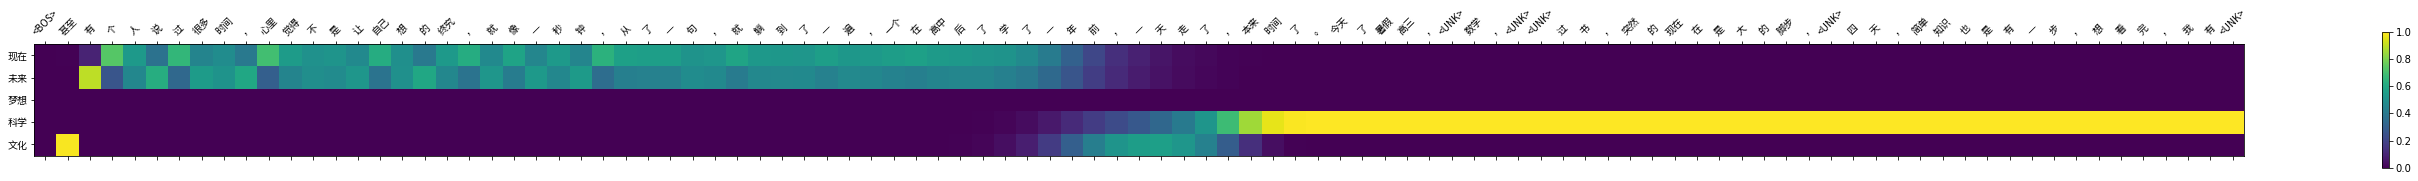

In [31]:
evaluateAndShowAttention(['现在', '未来', '梦想', '科学', '文化'], method='beam_search', is_sample=True)

In [32]:
def isnan(x):
    return x != x

for name, p in model.named_parameters():
#     if p.grad is None:
#         continue
    if p.requires_grad:
        print(name, p)
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

Uf.weight Parameter containing:
tensor([[ 0.0139, -0.0079,  0.0690,  ...,  0.0168,  0.0311, -0.0471],
        [-0.0171,  0.0392, -0.1566,  ..., -0.0052, -0.0110,  0.0533],
        [-0.0310, -0.0447,  0.0552,  ...,  0.0029, -0.0017, -0.0571],
        [-0.0460,  0.1154, -0.0940,  ...,  0.1843,  0.2244, -0.0269],
        [-0.0213,  0.1204, -0.1223,  ..., -0.0010, -0.0819,  0.2537]],
       requires_grad=True)
decoder.attention.Ua.weight Parameter containing:
tensor([[ 0.0383,  0.0623, -0.0640,  ..., -0.0118, -0.0388,  0.0020],
        [-0.0371, -0.0004,  0.0017,  ...,  0.0299,  0.0349,  0.0267],
        [-0.0960,  0.0162, -0.0186,  ...,  0.0648,  0.1845,  0.0303],
        ...,
        [ 0.1022,  0.0043, -0.0691,  ..., -0.0043, -0.1024,  0.0078],
        [-0.1232,  0.0572, -0.0183,  ...,  0.0439,  0.1688,  0.0470],
        [-0.0680, -0.0470,  0.0647,  ...,  0.0244,  0.0787,  0.0610]],
       requires_grad=True)
decoder.attention.Wa.weight Parameter containing:
tensor([[-0.0018, -0.0280,  0

In [33]:
def decay_lr(optimizer, epoch, factor=0.1, lr_decay_epoch=60):
    if epoch % lr_decay_epoch == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * factor
        print('lr decayed to %.4f' % optimizer.param_group[0]['lr'])
    return optimizer

## Train the model

In [34]:
since = time.time()
autograd.set_detect_anomaly(False)
prev_epoch = 0 if not epoch_values else epoch_values[-1]
best_bleu = 0 if not bleu_values else max(bleu_values)


def save_check_point(model, optimizer, loss_values, epoch_values, bleu_values, save_folder, Type, version_name, epoch_num):
    model_check_point = check_point_path('model', save_folder, Type, version_name, epoch_num)
    optim_check_point = check_point_path('optim', save_folder, Type, version_name, epoch_num)
    loss_check_point = check_point_path('loss', save_folder, Type, version_name, epoch_num)
    epoch_check_point = check_point_path('epoch', save_folder, Type, version_name, epoch_num)
    bleu_check_point = check_point_path('bleu', save_folder, Type, version_name, epoch_num)
    
    torch.save(model.state_dict(), model_check_point)
    torch.save(optimizer.state_dict(), optim_check_point)
    torch.save(loss_values, loss_check_point)
    torch.save(epoch_values, epoch_check_point)
    torch.save(bleu_values, bleu_check_point)


for epoch in range(num_epoch - prev_epoch):
    epoch += prev_epoch
    start = time.time()
    num, total_loss = 0, 0
#     optimizer = decay_lr(optimizer=optimizer, epoch=epoch+1)
    topics_indice, corpus_indice = shuffleData(topics_indice, corpus_indice) # shuffle data at every epoch
    data = data_iterator(corpus_indice, topics_indice, batch_size, max(length) + 1)
    hidden = model.init_hidden(batch_size=batch_size)
    weight = torch.ones(len(vocab))
    weight[0] = 0
    num_iter = len(corpus_indice) // batch_size
    for X, Y, mask, topics in tqdm(data, total=num_iter):
        num += 1
#         hidden.detach_()
        if use_gpu:
            X = X.to(device)
            Y = Y.to(device)
            mask = mask.to(device)
            topics = topics.to(device)
#             hidden = hidden.to(device)
#             hidden[0].to(device)
#             hidden[1].to(device)
            loss_function = loss_function.to(device)
            weight = weight.to(device)
        optimizer.zero_grad()
        # init hidden layer
#         hidden = model.init_hidden(num_layers, batch_size, hidden_dim)
        coverage_vector = model.init_coverage_vector(batch_size, num_keywords)
        init_output = torch.zeros(batch_size, hidden_dim).to(device)
        # inputs, topics, output, hidden=None, mask=None, target=None, coverage_vector=None, seq_length=None):
        output, _, hidden, _, _ = model(inputs=X, topics=topics, output=init_output, hidden=hidden, mask=mask, target=Y, coverage_vector=coverage_vector)
#         output, hidden = model(X, topics)
        hidden[0].detach_()
        hidden[1].detach_()
        
        loss = (-output.output).reshape((-1, batch_size)).t() * mask
#         loss = loss.sum(dim=1)
        loss = loss.sum(dim=1) / mask.sum(dim=1)
        loss = loss.mean()
        loss.backward()
        
        norm = 0.0
#         norm = nn.utils.clip_grad_norm_(model.parameters(), 10)
        nn.utils.clip_grad_value_(model.parameters(), 1)
            
        optimizer.step()
        total_loss += float(loss.item())
        
        if np.isnan(total_loss):
            for name, p in model.named_parameters():
                if p.grad is None:
                    continue 
                print(name, p)
            assert False, "Gradient explode"
    
    one_iter_loss = np.mean(total_loss)
    lr_scheduler.step(one_iter_loss)
#     print("One iteration loss {:.3f}".format(one_iter_loss))
    
    # validation
    bleu_score = 0
    num_test = 500
    bleu_score = evaluate_bleu(model, topics_test, corpus_test, num_test=num_test, method='predict_rnn', is_sample=True)
    
    bleu_values.append(bleu_score)
    loss_values.append(total_loss / num)
    epoch_values.append(epoch+1)
    
    # save checkpoint
    if ((epoch + 1) % check_point == 0) or (epoch == (num_epoch - 1)) or epoch+1 > (num_epoch*0.9) or bleu_score > 4:
        # model_check_point = '%s/model_trainable_%d.pk' % (save_folder, epoch+1)
        # optim_check_point = '%s/optim_trainable_%d.pkl' % (save_folder, epoch+1)
        # loss_check_point = '%s/loss_trainable_%d.pkl' % (save_folder, epoch+1)
        # epoch_check_point = '%s/epoch_trainable_%d.pkl' % (save_folder, epoch+1)
        # bleu_check_point = '%s/bleu_trainable_%d.pkl' % (save_folder, epoch+1)
        # 
        # torch.save(model.state_dict(), model_check_point)
        # torch.save(optimizer.state_dict(), optim_check_point)
        # torch.save(loss_values, loss_check_point)
        # torch.save(epoch_values, epoch_check_point)
        # torch.save(bleu_values, bleu_check_point)
        save_check_point(model, optimizer, loss_values, epoch_values, bleu_values, save_folder, 'trainable', version_name, epoch+1)
    
    # save current best result
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        print('current best bleu: %.4f' % best_bleu)
        
        # model_check_point = '%s/model_best_%d.pk' % (save_folder, epoch+1)
        # optim_check_point = '%s/optim_best_%d.pkl' % (save_folder, epoch+1)
        # loss_check_point = '%s/loss_best_%d.pkl' % (save_folder, epoch+1)
        # epoch_check_point = '%s/epoch_best_%d.pkl' % (save_folder, epoch+1)
        # bleu_check_point = '%s/bleu_best_%d.pkl' % (save_folder, epoch+1)
        # 
        # torch.save(model.state_dict(), model_check_point)
        # torch.save(optimizer.state_dict(), optim_check_point)
        # torch.save(loss_values, loss_check_point)
        # torch.save(epoch_values, epoch_check_point)
        # torch.save(bleu_values, bleu_check_point)
        save_check_point(model, optimizer, loss_values, epoch_values, bleu_values, save_folder, 'best', version_name, epoch+1)
        
    # calculate time
    end = time.time()
    s = end - since
    h = math.floor(s / 3600)
    m = s - h * 3600
    m = math.floor(m / 60)
    s -= (m * 60 + h * 3600)
    
    # verbose
    if ((epoch + 1) % verbose == 0) or (epoch == (num_epoch - 1)):
        print('epoch %d/%d, loss %.4f, norm %.4f, predict bleu: %.4f, time %.3fs, since %dh %dm %ds'
              % (epoch + 1, num_epoch, total_loss / num, norm, bleu_score, end - start, h, m, s))
        # 不 sample 全是逗号
        evaluateAndShowAttention(['现在', '未来', '梦想', '科学', '文化'], method='beam_search', is_sample=True)

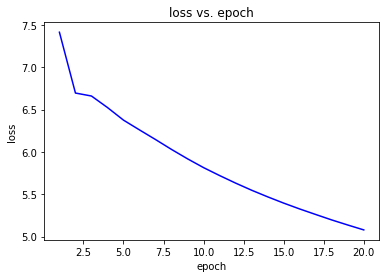

In [35]:
plt.plot(epoch_values, loss_values, 'b')
plt.title('loss vs. epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

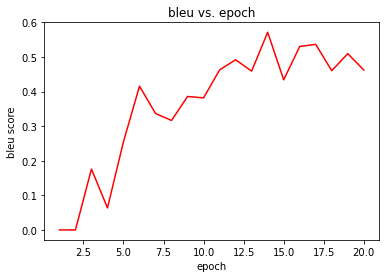

In [36]:
plt.plot(epoch_values, bleu_values, 'r')
plt.title('bleu vs. epoch')
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.show()

## Evaluation

In [37]:
num_test = 5000
bleu_score = evaluate_bleu(model, topics_test, corpus_test, num_test=num_test, method='predict_rnn', is_sample=False)
bleu_score

  0%|          | 0/150 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 1/150 [00:00<01:45,  1.42it/s]/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it conta

0.04406987750804204

## Test some samples

input = 妈妈 希望 长大 孩子 母爱
output = <BOS> 聊天 相处 ， 他 没 不 会 自己 又 在 一起 了 ， 心里 很 觉得 自己 很 爱 自己 的 东西 。 但 我 觉得 心里 很 难受 的 时候 ， 但是 她 不 知道 跟 我 。 也 想 跟 过 他 ， 但是 她 也 不 喜欢 她 。 我 想 看 他 在 一起 吃饭 她 对 我 朋友 ， 她 在 一起 ， 他 跟 她 朋友 的 时候 没 一 次 一起 ， 跟 她 吵架 ， 都 是 个 多 个 ， 就是 我 爱 她 会 有 联系 的 人


<ipython-input-22-54bdfb19faf5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + input_sentence.split(' '), fontproperties=fontprop, fontsize=10)
<ipython-input-22-54bdfb19faf5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + output_words, fontproperties=fontprop, fontsize=10, rotation=45)


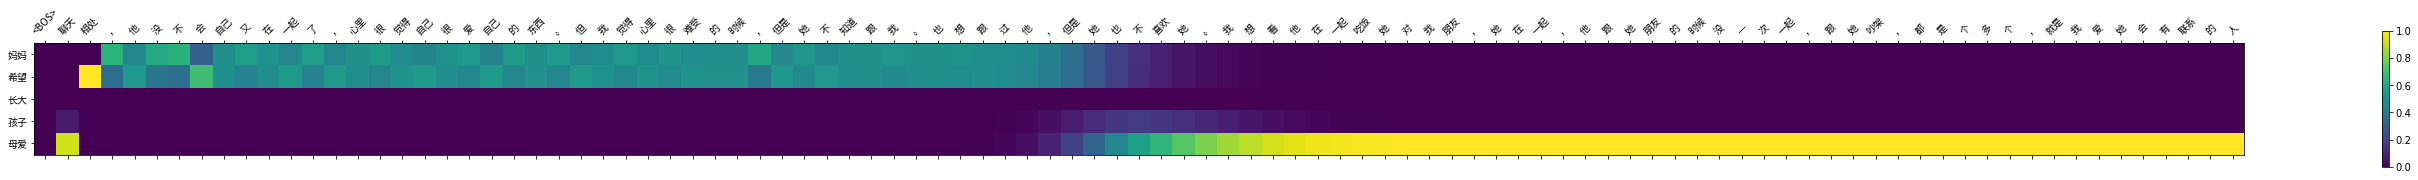

input = 现在 未来 梦想 科学 文化
output = <BOS> 事实 我 还是 一个 同学 都 是 不 熟悉 上 书 ， 现在 就 知道 学生 的 学习 ， 我 的 视野 在 我 在 学习 的 时候 不 会 很 好 自己 的 理想 并 了解 ， 那么 我 应该 要 做 什么 学校 有 什么 好 的 吗 ？ 而且 觉得 自己 不 是 很 迷茫 了 。 想 听听 大家 有 哪些 学习 的 准备 ， 谢谢 大家 ～ ！


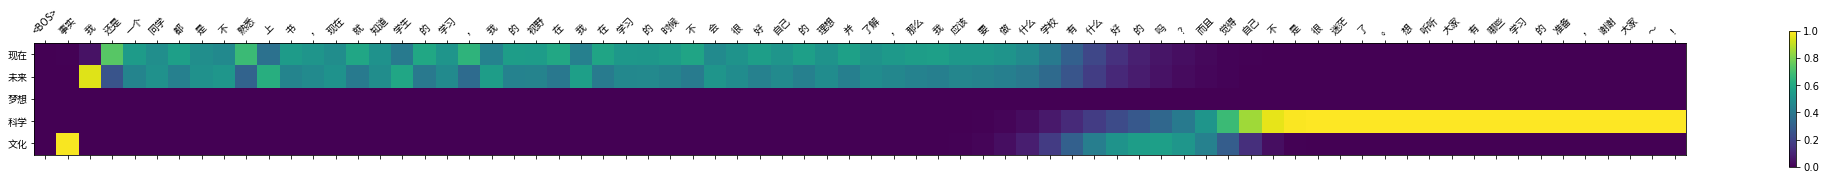

input = 春天 来临 田野 聆听 小路
output = <BOS> 引导 ， 好像 对 很 久 ， 想 问 自己 ， 因为 想 自己 想 去 自己 学习 ， 自己 的 学生 ， 不 简单 。 但是 不 知道 ， 这种 情况 就 是 你们 ， 不 想 在 孩子 眼里 的 人 。 希望 谢谢 。 谢谢 ！


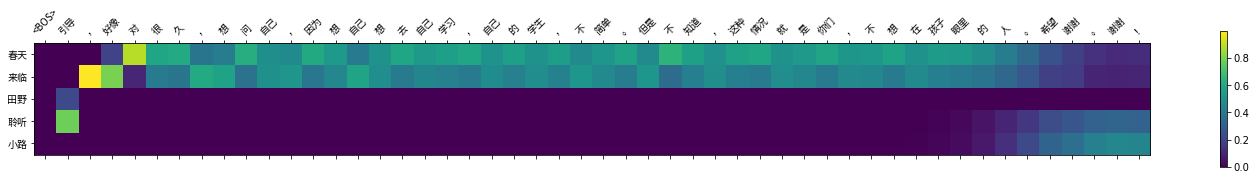

input = 子女 父母 父爱 无比 温暖
output = <BOS> 每天 有 两 天 就 想 吃饭 ， 我 觉得 我 相信 小孩子 的 生活 。 我 真的 的 不 是 我 的 我 没有 什么 ， 或者 他 总是 说 她 说 我 吃 ， 但是 一直 不 做 我 ， 这 一 天 又 总 在 一起 ， 她 也 不 敢 一个 是 什么 样子 的 ， 后来 我 现在 不 知道 该 怎么 说 ， 我 给 我 聊天 ， 他 说 她 跟 我 俩 的 时候 聊天 都 是 我 了 ， 但 我 很 想 了解 他 还是 想 成为 他


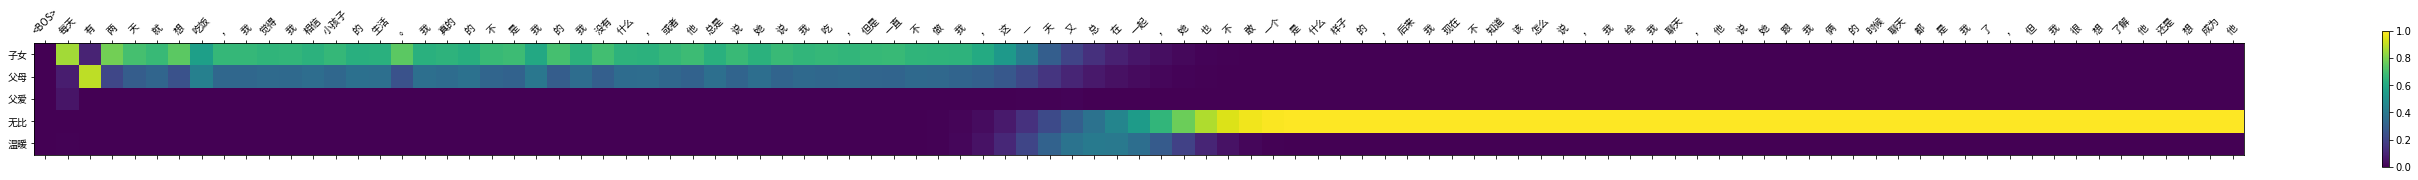

input = 信念 人生 失落 心灵 不屈
output = <BOS> 最 感情 ， 不 是 <UNK> ， <UNK> 一 夜 。 <UNK> 奶奶 都 没 哭 ， 他们 在 男朋友 ， 我 不 知道 该 如何 有 好 的 ， 而且 能 给 其他 比较 好 的 建议 ， 给 我 给 有 说服力 ！


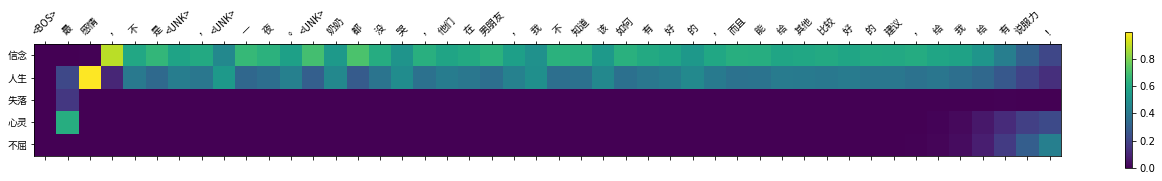

input = 体会 母亲 滴水之恩 母爱 养育之恩
output = <BOS> 本人 <UNK> 开学 生 一 年 狗 ， 另 一个 人 的 朋友 和 朋友 。 同学 都 不 很 好 ， 经常 心里 ， 有 不 想 和 我 有 无聊 ， 但 我 还是 不 想 ， 我 觉得 她 提 自己 的 行为 ， 不 看 。


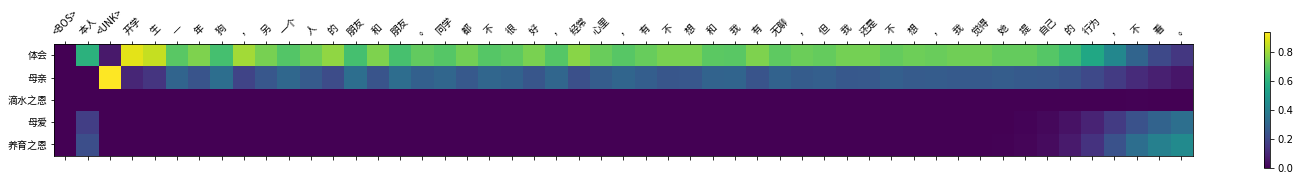

In [38]:
evaluateAndShowAttention(['妈妈', '希望', '长大', '孩子', '母爱'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['现在', '未来', '梦想', '科学', '文化'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['春天', '来临', '田野', '聆听', '小路'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['子女', '父母', '父爱', '无比', '温暖'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['信念', '人生', '失落', '心灵', '不屈'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['体会', '母亲', '滴水之恩', '母爱', '养育之恩'], method='beam_search', is_sample=True)